# Determine all stellar properties, i.e. Teff, R, L from photometry, empirical relations and spectra
## Create plots for paper and tables for analysis and AltaiPony input list

In [2]:
from copy import copy

import numpy as np
import pandas as pd

import specmatchemp.library

from opencluster.lum import remove_outlier_Teffs, read_Kepler_response
from opencluster.opencluster import OpenCluster

from opencluster.paperplots import (import_matplotlib_style,
                                    plot_interconnected_subplots,
                                    MARKERS_LIST,
                                    CB_COLOR_CYCLE)

from gaia.gaia import calculate_distance_from_parallax

import matplotlib.pyplot as plt
%matplotlib inline
import_matplotlib_style()

from matplotlib import rcParams
rcParams["errorbar.capsize"] = .0

import time
tstamp = time.strftime("%d_%m_%Y", time.localtime())

## Define all the plot functions

In [3]:
def plot_Teff_spread(df, figsize=(9,7), outdir="plots/", kpmax=9., tstamp=""):
    
    # define a DataFrame with Teffs only
    df = df[((df["KEP Mag"].isnull()) | (df["KEP Mag"] > kpmax))] # do not plot above saturation level
    cols = df.columns.str.contains("Teff_")
    colvals = df.columns.values[df.columns.str.startswith("Teff_")]
    Teffs = df.loc[:,cols]
    Teffs["Teff_median"] = df.Teff_median
    
    # set layout and labels
    markers = copy(MARKERS_LIST)
    colors = copy(CB_COLOR_CYCLE)
    cdict = dict(zip(list("grizy"),[i + "_SDSS" for i in list("grizy")]))
    c2 = dict(zip(list("JHK"),[i + "_2MASS" for i in list("JHK")]))
    c3 = dict(zip(["BP","RP"],[i + "_Gaia_corr" for i in ["BPRP","BPRP"]]))
    cdict.update(c2)
    cdict.update(c3)
    
    # create a DataFrame with colors and Teffs to plot
    i=0
    xs, ys, xr, yr = [], [], [], []
    dd = pd.DataFrame()
    for c in colvals[0:-2]:
        if ~(Teffs[c].isnull().all()):
            cl = " - ".join(c.split("_")[1:])
            if "Mann" in cl:
                col1, col2 = c.split("_")[2:4]
                col1, col2 = cdict[col1],cdict[col2]
                if col1==col2:
                    x = df[col1]
                    cl = "BP - RP (Mann)"
                    xerr = df["e_" + col1]
                else:
                    
                    x= df[col1]-df[col2]
                    xerr = np.sqrt(df["e_" + col1]**2 + df["e_" + col2]**2)
            elif ("StarHorse" in cl) or ("Apsis" in cl):
                exten = cl.split("_")[-1]
                cl = "BP - RP ({})".format(exten)
                x = df.BP_Gaia - df.RP_Gaia
                xerr = np.sqrt(df.e_BP_Gaia**2 + df.e_RP_Gaia**2)
            else:
                col1, col2 = c.split("_")[1:3]
                col1, col2 = cdict[col1],cdict[col2]
                x= df[col1]-df[col2]
                xerr = np.sqrt(df["e_" + col1]**2 + df["e_" + col2]**2)
            
            cl = cl.replace("Mann - ", "")
            cl = cl.replace("- Boy", "")
            cl = cl.replace(" - FeH", "")
            for j in range(5):
                cl = cl.replace(" - {}".format(j)," ({})".format(j))
            dd[cl] = x
            dd["e_" + cl] = xerr
            dd["y"+str(i)] = Teffs[c]
            dd["e_y"+str(i)] = Teffs["e_" + c]
            xs.append(cl)
            ys.append("y" + str(i))
            xr.append("e_" + cl) 
            yr.append("e_y"+str(i))
            i +=1
            
    #plot the thing
    fig, axes = plot_interconnected_subplots(dd,xs,ys,err=True,
                                             xerr=xr,yerr=yr,
                                             width=2.5, height=6,alpha=.05)
    axes[0].set_ylabel(r"$T_\mathrm{eff}$ [K]")
    for i, ax in enumerate(axes):
        ax.set_xlabel(xs[i])
    plt.subplots_adjust(wspace=0.05, left=0.05, right=0.95)
    plt.savefig(f"{outdir}{tstamp}_Teff_spread_all.png", dpi=300)    
    
    
def plot_Teff_R(df, figsize=(9,7), outdir="plots/", title="", tstamp=""):
    plt.figure(figsize=figsize)
    plt.errorbar(x=df.Teff_median,xerr=df.Teff_std,c="k",
                     y=df.Rstar, yerr=df.e_Rstar, fmt="o", markersize=1, linewidth=.2)
    plt.title(title)
    plt.xlim(7000, 2700)
    plt.ylim(.1,1.7)
    plt.xlabel(r"$T_{\mathrm{eff}}$ [K]")
    plt.ylabel(r"$R_* / R_{\odot}$")
    plt.savefig(f"{outdir}{tstamp}_Teff_R.png", dpi=300)

## Now loop over each cluster and save some plots and tables

In [4]:
# First, read some ancillary data
Kp = read_Kepler_response()
lib = specmatchemp.library.read_hdf(wavlim=[Kp.wav.min(),Kp.wav.max()]) #takes a little while

Reading library from /home/ekaterina/.specmatchemp/library.h5


# Cluster luminosities and other properties

In [5]:
path = "../FlareAnalysisPipeline/opencluster/clusters"
params = pd.read_csv(f'{path}/cluster_parameters_merged.csv')
 

In [6]:
clusters = ["pleiades", "hyades", "praesepe", "ngc6774", "ngc2682"]
cl = pd.read_csv('{}/cluster_parameters_merged.csv'.format(path))
for cluster in clusters:
    

    
    #Save stellar parameters, all of them!
    
    flares = pd.read_csv("../k2scoc/results/tables/full_table.csv")
    hasflares = (flares.real==1) & (flares.todrop.isnull())
    wassearched = (flares.real==0) & (flares.todrop.isnull())
    excluded = (flares.real==-1) & (flares.todrop.isnull())
    flares = flares[hasflares  | wassearched ]
    df = pd.read_csv(f'luminosities/{cluster}_luminosities.csv')
    s =  flares.loc[flares.cluster==cluster,["EPIC",]].drop_duplicates()
    searched = s.shape[0]
    altai = df.loc[(~df.Teff_median.isnull()) & (df.todrop.isnull()) &
                         ((df["KEP Mag"].isnull()) | (df["KEP Mag"] > 9.)) &
                         (df["Teff_median"] < 7000.),
                         :].drop_duplicates(subset=["EPIC","Campaign"])#['EPIC', 'Channel', 'Campaign'] #.fillna(0).astype(int)
    altai = altai.loc[(altai.EPIC<3e8) & (altai.EPIC>1e8),:]
    altai = altai.merge(s[["EPIC"]], how="right", on="EPIC")
    print(altai.EPIC.shape[0],searched)
    print(set(altai.EPIC)-set(s.EPIC))
#    altai.to_csv(f"luminosities/{cluster}_luminosities_in_final_flare_tables.csv",index=False)
#     plot_Teff_spread(altai, outdir=f"plots/{tstamp}_{cluster}")
#     plot_Teff_R(altai, outdir=f"plots/{tstamp}_{cluster}",
#                 title=params[params.cluster==cluster].h_cluster.iloc[0])


761 761
set()
171 171
set()
964 964
set()
53 53
set()
307 307
set()


761 761
set()
171 171
set()
964 964
set()
53 53
set()
307 307
set()


cluster       ngc2168
h_cluster         M35
age (Myr)       147.5
FeH             -0.21
dist (pc)         861
u_age_high       13.5
u_age_low        13.5
u_feh             0.1
Name: 1, dtype: object
Number of Teff_g_r_Boy  128
Number of Teff_g_z_Boy  152
Number of Teff_g_i_Boy  152
Number of Teff_g_J_Boy  150
Number of Teff_g_H_Boy  150
Number of Teff_g_K_Boy  150
Number of Teff_Mann_BP_RP_nan  157
Number of Teff_Mann_r_z_nan  152
Number of Teff_Mann_r_J_nan  151
Number of Teff_Mann_BP_RP_FeH  157
Number of Teff_Mann_r_z_FeH  152
Number of Teff_Mann_r_J_FeH  151
Number of Teff_Mann_BP_RP_isJH  156
Number of Teff_Mann_r_z_isJH  151
Number of Teff_Mann_r_J_isJH  151
['Teff_Mann_BP_RP_nan' 'Teff_Mann_r_z_nan' 'Teff_Mann_r_J_nan'
 'Teff_Mann_BP_RP_FeH' 'Teff_Mann_r_z_FeH' 'Teff_Mann_r_J_FeH'
 'Teff_Mann_BP_RP_isJH' 'Teff_Mann_r_z_isJH' 'Teff_Mann_r_J_isJH'] ['e_Teff_Mann_BP_RP_nan' 'e_Teff_Mann_r_z_nan' 'e_Teff_Mann_r_J_nan'
 'e_Teff_Mann_BP_RP_FeH' 'e_Teff_Mann_r_z_FeH' 'e_Teff_Mann_r_J_F

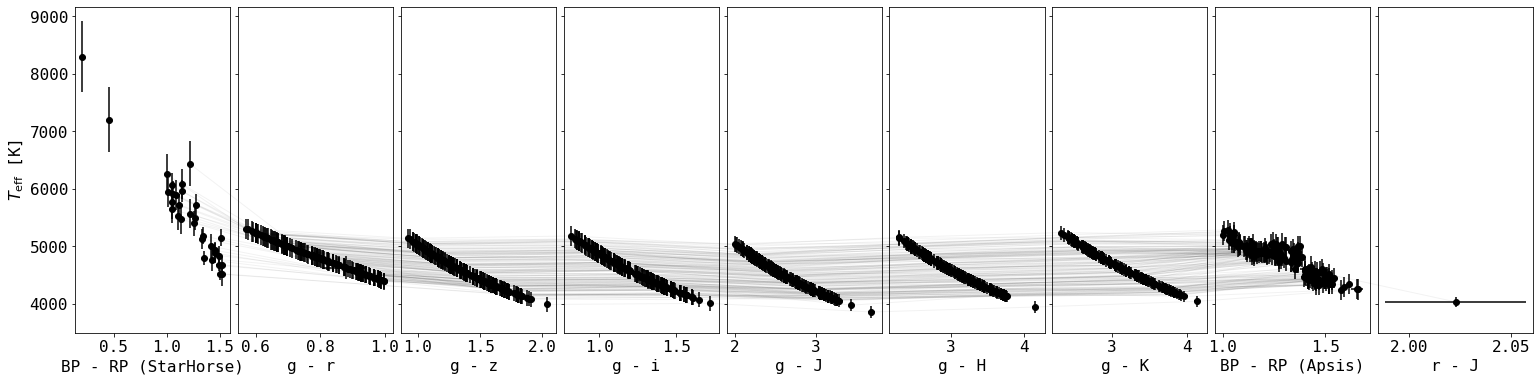

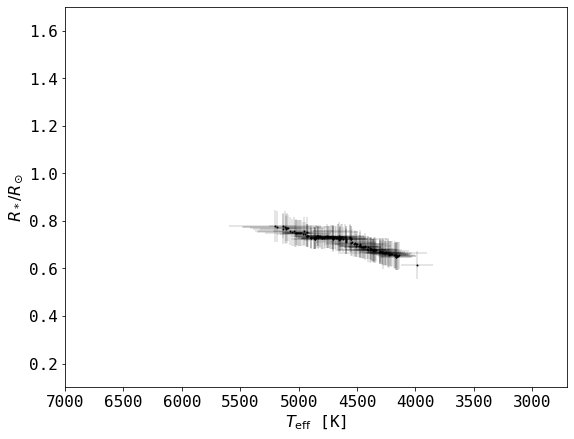

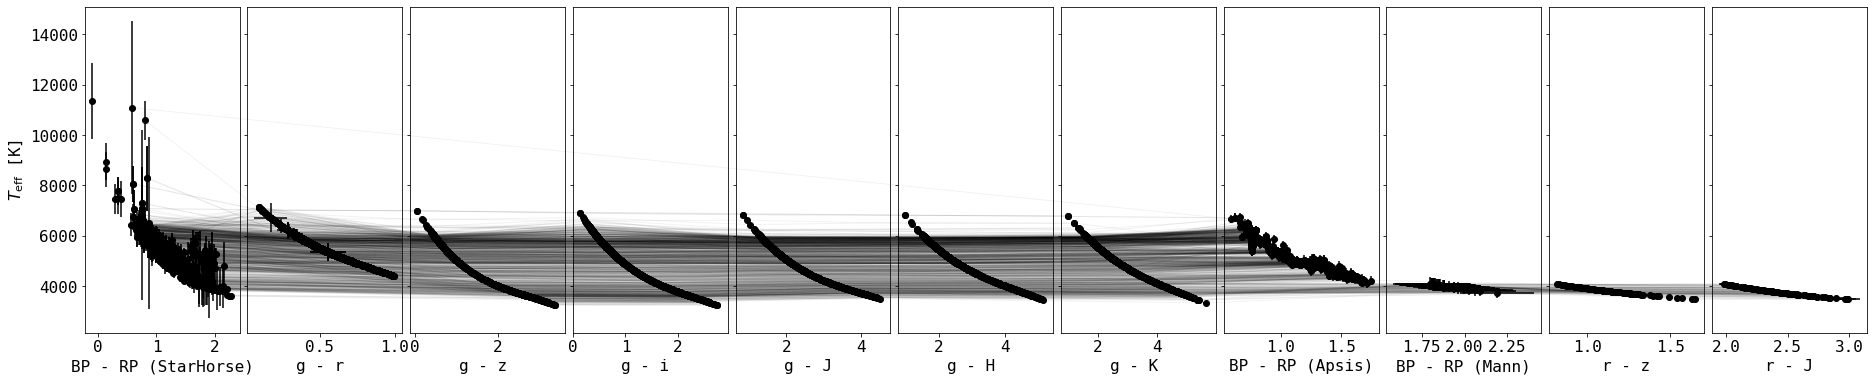

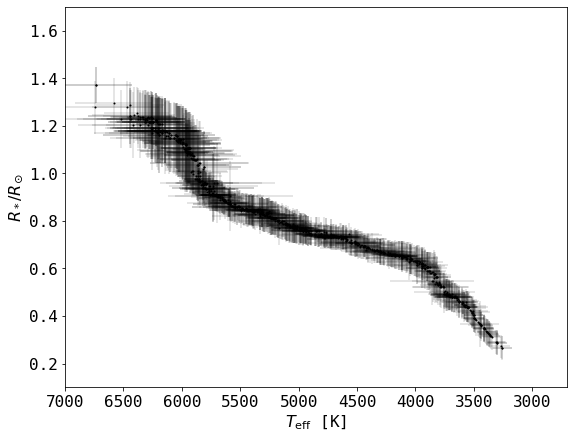

In [8]:
clusters = ["pleiades", "hyades", "praesepe", "ngc6774", "ngc2682",  "ngc2168",]
cl = pd.read_csv('{}/cluster_parameters_merged.csv'.format(path))
for cluster in clusters[:-1]:
    #Read in the cluster parameters
    
    r = cl[cl.cluster == cluster].iloc[0]
    print(r)
    # Init an OpenCluster

    stellar_parameters = pd.read_csv('cmd/cmd_flagged/{}_cmd.csv'.format(r.cluster))
    OC = OpenCluster(cluster=r.cluster, h_cluster=r.h_cluster, age=r["age (Myr)"],
                         u_age_high=r.u_age_high, u_age_low=r.u_age_low,
                         stars=stellar_parameters, feh=r.FeH, u_feh=r.u_feh,
                         distance=r["dist (pc)"], prep=False)

    # Throw out stars that are obviously foreground object
    dft = OC.stars.loc[:,OC.stars.columns.str.contains("Gaia")].rename(columns = lambda x : str(x)[:-5])
    dft = calculate_distance_from_parallax(dft, check_GoF=False)
    OC.stars = OC.stars[dft.distance > 0.5 * OC.distance]
    
    if cluster == "ngc2682":
        OC.stars["RAJ2000__Gaia"] = OC.stars['ra_epoch2000_Gaia'].values  
        OC.stars["DEJ2000__Gaia"] = OC.stars['dec_epoch2000_Gaia'].values

    OC.determine_Teff()

    # Find R_*:

    OC.find_Rstar(lib)

    # Find SED:

    h = OC.find_SED(lib)

    # Calculate the luminosities:

   # OC.calculate_luminosities()
    
    # plot all the things:
    
    plot_Teff_spread(OC.stars, tstamp=tstamp)
    plot_Teff_R(OC.stars, tstamp=tstamp)
    
    #Save stellar parameters, all of them!
  #  OC.stars.to_csv('luminosities/{}_luminosities.csv'.format(r.cluster), index=False)

    #However, minimum requirement to be included into the AltaiPony list is to have a Teff value assigned.
    # This Teff values must correspond to a star with SpT > F4 and not be saturated in the Kepler detector
    altai = OC.stars.loc[(~OC.stars.Teff_median.isnull()) &
                         ((OC.stars["KEP Mag"].isnull()) | (OC.stars["KEP Mag"] > 9.)) &
                         (OC.stars["Teff_median"] < 7000.),
                         ['EPIC', 'Channel', 'Campaign']].fillna(0).astype(int).drop_duplicates()
 #   altai.to_csv('altai/{}_altai.csv'.format(r.cluster), index=False)

# Overlay of all Teff-R

cluster       pleiades
h_cluster     Pleiades
age (Myr)          135
FeH             -0.037
dist (pc)        135.6
u_age_high          25
u_age_low           25
u_feh             0.03
Name: 4, dtype: object
Number of Teff_g_r_Boy  46
Number of Teff_g_z_Boy  224
Number of Teff_g_i_Boy  233
Number of Teff_g_J_Boy  284
Number of Teff_g_H_Boy  241
Number of Teff_g_K_Boy  251
Number of Teff_Mann_BP_RP_nan  903
Number of Teff_Mann_r_z_nan  745
Number of Teff_Mann_r_J_nan  742
Number of Teff_Mann_BP_RP_FeH  903
Number of Teff_Mann_r_z_FeH  745
Number of Teff_Mann_r_J_FeH  742
Number of Teff_Mann_BP_RP_isJH  892
Number of Teff_Mann_r_z_isJH  735
Number of Teff_Mann_r_J_isJH  735
['Teff_Mann_BP_RP_nan' 'Teff_Mann_r_z_nan' 'Teff_Mann_r_J_nan'
 'Teff_Mann_BP_RP_FeH' 'Teff_Mann_r_z_FeH' 'Teff_Mann_r_J_FeH'
 'Teff_Mann_BP_RP_isJH' 'Teff_Mann_r_z_isJH' 'Teff_Mann_r_J_isJH'] ['e_Teff_Mann_BP_RP_nan' 'e_Teff_Mann_r_z_nan' 'e_Teff_Mann_r_J_nan'
 'e_Teff_Mann_BP_RP_FeH' 'e_Teff_Mann_r_z_FeH' 'e_Teff_Man

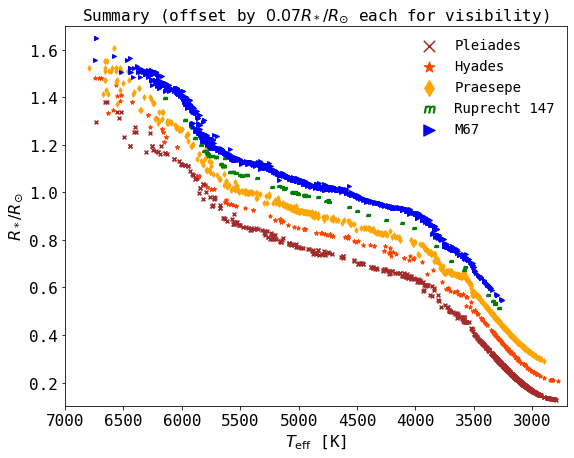

In [40]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(9,7))
clusters = [("pleiades","brown", "x", "Pleiades"),
            ("hyades","orangered", "*", "Hyades"),
            ("praesepe", "orange", "d", "Praesepe"),
            ("ngc6774", "green",r"$m$", "Ruprecht 147"),
            ("ngc2682", "blue", ">", "M67")]
cl = pd.read_csv('{}/cluster_parameters_merged.csv'.format(path))
for j, (cluster, color, mark,label) in enumerate(clusters):
    #Read in the cluster parameters
    
    r = cl[cl.cluster == cluster].iloc[0]
    print(r)
    # Init an OpenCluster

    stellar_parameters = pd.read_csv('cmd/cmd_flagged/{}_cmd.csv'.format(r.cluster))
    OC = OpenCluster(cluster=r.cluster, h_cluster=r.h_cluster, age=r["age (Myr)"],
                         u_age_high=r.u_age_high, u_age_low=r.u_age_low,
                         stars=stellar_parameters, feh=r.FeH, u_feh=r.u_feh,
                         distance=r["dist (pc)"], prep=False)

    # Throw out stars that are obviously foreground object
    dft = OC.stars.loc[:,OC.stars.columns.str.contains("Gaia")].rename(columns = lambda x : str(x)[:-5])
    dft = calculate_distance_from_parallax(dft, check_GoF=False)
    OC.stars = OC.stars[dft.distance > 0.5 * OC.distance]
    
    if cluster == "ngc2682":
        OC.stars["RAJ2000__Gaia"] = OC.stars['ra_epoch2000_Gaia'].values  
        OC.stars["DEJ2000__Gaia"] = OC.stars['dec_epoch2000_Gaia'].values

    OC.determine_Teff()

    # Find R_*:

    OC.find_Rstar(lib)

    # Find SED:

 #   h = OC.find_SED(lib)

    # Calculate the luminosities:

   # OC.calculate_luminosities()
    
    # plot all the things:
    
    df=OC.stars
    
    ax.scatter(x=df.Teff_median,c=color,
                     y=df.Rstar + j / 14.28, marker=mark, s=15, label=label)
ax.set_title(r"Summary (offset by $0.07R_*/R_{\odot}$ each for visibility)")
ax.set_xlim(7000, 2700)
ax.set_ylim(.1,1.7)
ax.set_xlabel(r"$T_{\mathrm{eff}}$ [K]")
ax.set_ylabel(r"$R_* / R_{\odot}$")
# ax.legend(frameon=False, fontsize=14)

lgnd = ax.legend(loc="upper right", scatterpoints=1, fontsize=14, frameon=False)
for x in range(5):
    lgnd.legendHandles[x]._sizes = [130]
plt.savefig(f"plots/{tstamp}_Teff_R.png", dpi=300)


In [37]:
1/14.28

0.0700280112044818